# SISTEMA SEGMENTADOR DE VESTIDOS

Para esta parte del proyecto realizaremos un Sistema Segmentador de Vestidos, que consiste en recibir como entrada imágenes de personas usando vestidos, y a partir de estás identificar que parte es el vestido, que parte es la piel, que parte es la persona y que parte es el fondo. 

Esto con el fin de que, una vez entrenado el modelo, a partir de cuaqluier imagen cargada se pueda identificar únicamente el vestido. 

El principal desafió en este problema de segmentación estará en el ruido de las imágenes, ej. confundir el cabello con parte del vestido, accesorios que tengan las personas, fondos de colores poco contrastantes respecto al color del vestido, etc. Por ello, buscamos apoyarnos de distintos métodos que nos ayuden a procesar de mejor forma las imágenes.

Este segmentador es muy útil, ya que nos puede servir para identificar únicamente el vestido y en complemento al "Sistema de Recomendación de Vestidos" buscar vestidos similares al vestido original. ¿Pero porqué no simplemente utilizar la imágen de la persona completa? Porque para buscar la similitud de vestidos, necesitamos eliminar el ruido, es decir el entorno y a la persona misma, solo dejando el producto.

Y es muy versatil, ya que se pueden utilizar estos programas en una aplicación en la que solo tomas una foto con tu celular y te muestra todos los vestidos similares que se encuentran en determinada tienda.


In [1]:
import tqdm

import cv2
import numpy as np
from matplotlib import pyplot as plt
import urllib

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**ANÁLIZANDO LOS DATOS**

Debido a que vamos a utilizar imágenes de Internet, dentro del repositorio ya se tienen 20 imagenes de vestidos previamente cargadas y enumeradas del 0 al 19 y agrupadas por original, vestido y cuerpo. Por lo que recomendamos que las cargues en Drive y las leas desde ahí o las cargues directamente en Collab:
*   #original.jpg: Contiene la imagen original
*   #vestido.jpg: Contiene el vestido recortado de la imagen original
*   #cuerpo.jpg: Contiene el cuerpo (persona y vestido) recortado de la imagen original

Esta forma de dividir las imágenes es crear máscaras, ya que en cualquier tarea de segmentación de objetos, si queremos entrenar un modelo, es necesario indicarle en que puntos de interés enfocarse.

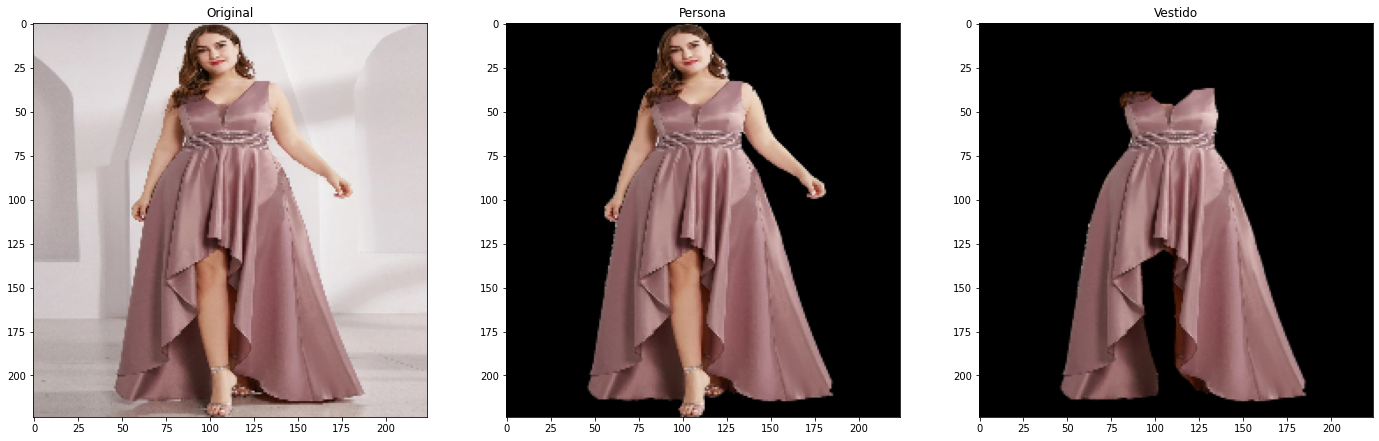

In [4]:
# Cargamos las imagenes para el Ejemplo 0 y las mostramos

original = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/0original.jpg')
original = cv2.resize(original,(224,224))
vestido = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/0vestido.jpg')
vestido = cv2.resize(vestido,(224,224))
cuerpo = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/0cuerpo.jpg')
cuerpo = cv2.resize(cuerpo,(224,224))

plt.figure(figsize=(24,12))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Persona')
plt.imshow(cv2.cvtColor(cuerpo, cv2.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Vestido')
plt.imshow(cv2.cvtColor(vestido, cv2.COLOR_BGRA2RGB))

De esta forma podemos crear nuestras máscaras tal como se muestran a continuación, lograndolo gracias a la binarización de la imagen. Para obtener la piel nos apoyamos con la imagen de la Persona y el Vestido, que sería una diferencia de estas.

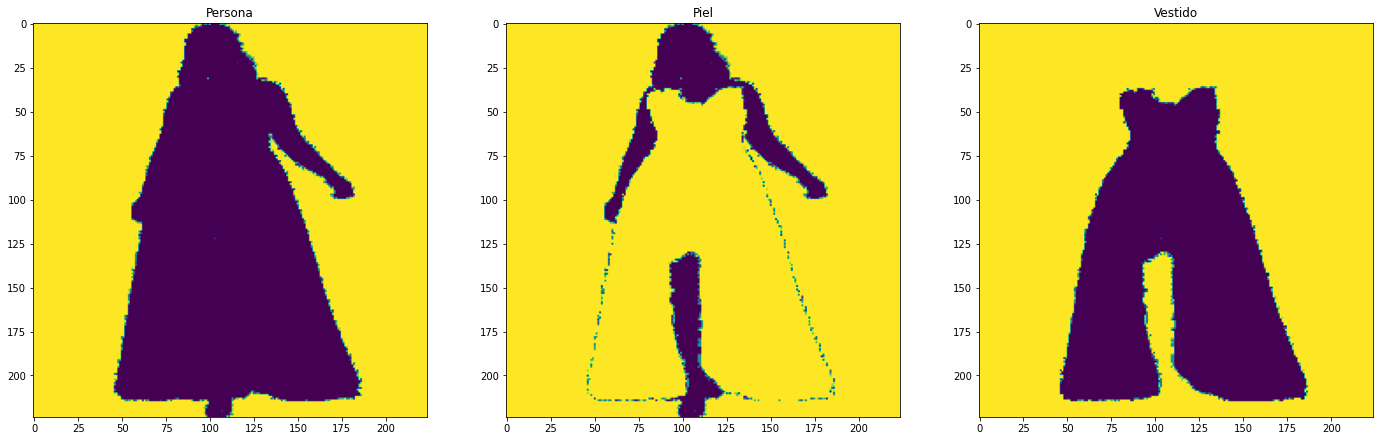

In [5]:
vestido = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/0vestido.jpg',0)
cuerpo = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/0cuerpo.jpg',0)

# Encode del Vestido
vestido[vestido == 255] = 0
vestido[vestido > 0] = 255
vestido = cv2.resize(vestido,(224,224))

# Encode del Cuerpo
cuerpo[cuerpo == 255] = 0
cuerpo[cuerpo > 0] = 255
cuerpo = cv2.resize(cuerpo,(224,224))

# Encode de la Piel
piel = cuerpo - vestido

plt.figure(figsize=(24,12))
plt.subplot(1,3,1)
plt.title('Persona')
bg = (255 - cuerpo)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Piel')
piel = (255 - piel)/255
plt.imshow(piel)
plt.subplot(1,3,3)
plt.title('Vestido')
vestido = (255 - vestido)/255
plt.imshow(vestido)

Ahora, integramos todo en una sola imagen, en la cual se decodifican las características que nos interesan de nuestra imagen original. 

En realidad el objetivo es separar el fondo, el vestido y la piedl, y se logró perfectamente.

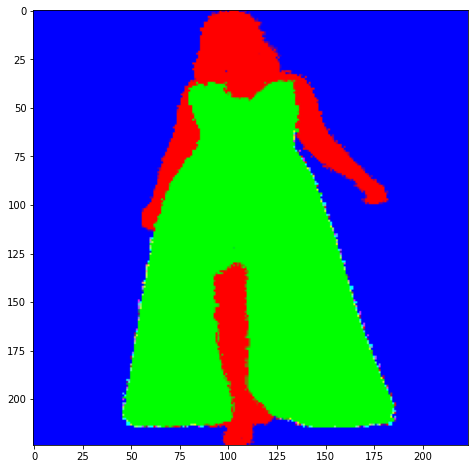

In [ ]:
# Combinamos el Fodno, la Piel y el Vestido en colores RGB

gt = np.zeros((224,224,3))
gt[:,:,0] = (1-piel)
gt[:,:,1] = (1-vestido)
gt[:,:,2] = bg

plt.figure(figsize=(8,8))
plt.imshow(gt)

Es momento de aplicar este proceso para cada una de las imágenes que tenemos que son 20, es decir iteramos de la imagen 1 a la 19, ya que la 0 ya la usamos en el ejemplo.

Con esto obtendremos la máscara asociada de tres dimensiones para cada una de las imágenes.

Es importante que previo al entrenamiento se estandaricen todas las imágenes originales con su media RGB.


100%|██████████| 16/16 [00:01<00:00, 11.49it/s]


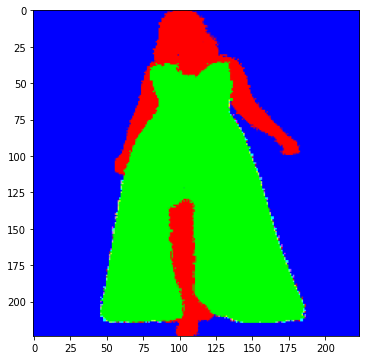

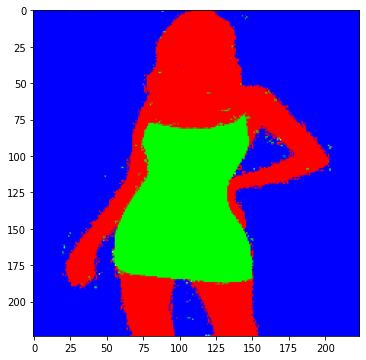

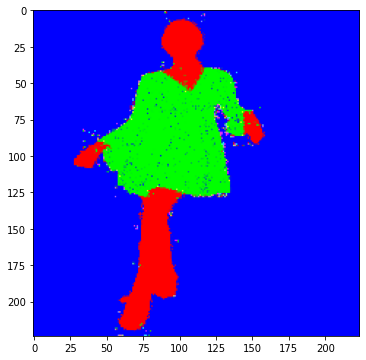

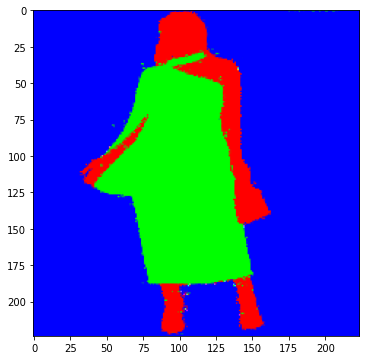

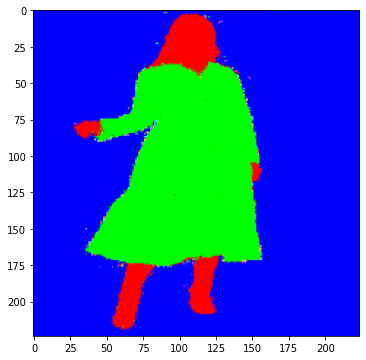

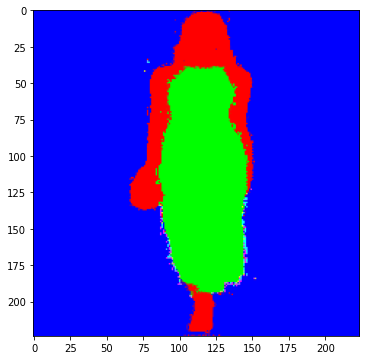

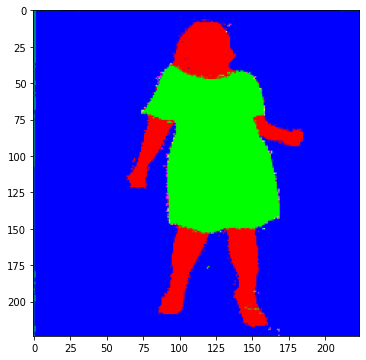

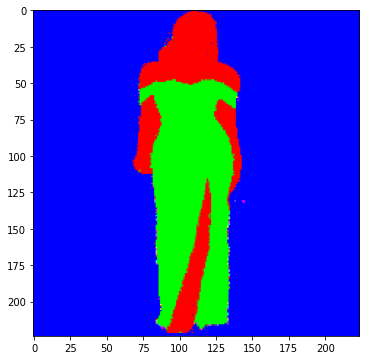

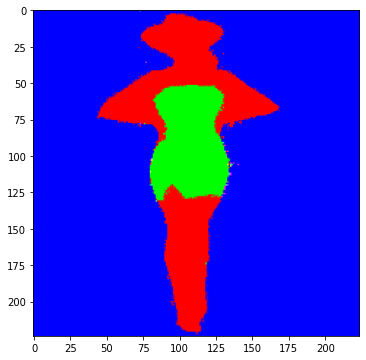

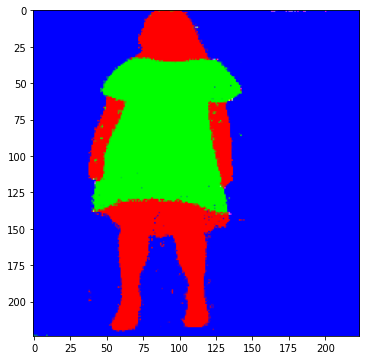

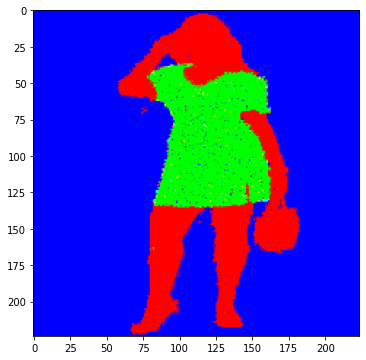

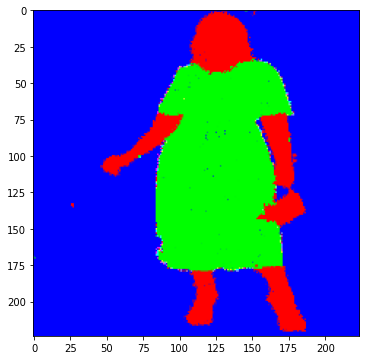

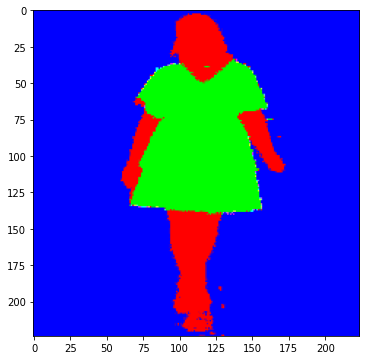

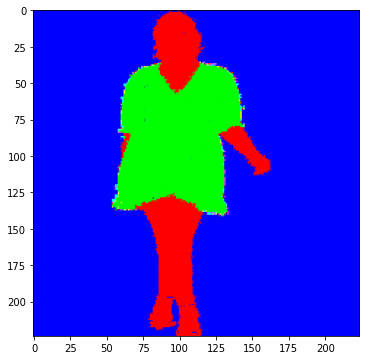

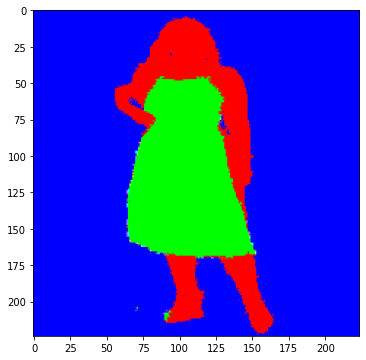

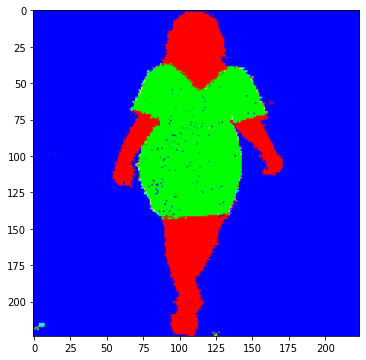

In [ ]:
# Encode del Fondo, la Piel y el Vestido para todas las imágenes de Entrenamiento

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 16

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/'+str(i)+'original.jpg')
    original = cv2.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    cuerpo = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/'+str(i)+'cuerpo.jpg',0)
    vestido = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/'+str(i)+'vestido.jpg',0)
    
    vestido[vestido == 255] = 0
    vestido[vestido > 0] = 255
    vestido = cv2.resize(vestido,(224,224))

    cuerpo[cuerpo == 255] = 0
    cuerpo[cuerpo > 0] = 255
    cuerpo = cv2.resize(cuerpo,(224,224))

    piel = cuerpo - vestido
    bg = (255 - cuerpo)/255
    piel = (255 - piel)/255
    vestido = (255 - vestido)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-piel)
    gt[:,:,1] = (1-vestido)
    gt[:,:,2] = bg

    plt.figure(figsize=(6,6))
    plt.imshow(gt)
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.reshape((-1,224,224,3))

images_original = np.asarray(images_original)
images_gt = np.asarray(images_gt)

**ANALIZANDO EL MODELO**
Solo tomamos en cuenta el canal de nuestro interés que es el vestido, creamos la máscara a partir de la imágen de entrada y lo recortamos para recrear el vestido original.

**Autoencoder convolucional profundo UNet**

Esto lo hacemos con ayuda del Autoencoder convolucional profundo UNet, que de hecho se utiliza en gran medida en las tareas de segmentación. Lo replicamos en Keras y lo entrenamos para recrear píxel por píxel cada canal de nuestra máscara deseada.

In [ ]:
def get_unet(mean_pixels, do_rate=0):
  
    inputs = Input((None, None, 3))
    preproc = Lambda(lambda x: (x - tf.constant(mean_pixels, dtype=tf.float32)))(inputs) 

    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(preproc))
    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(pool1))
    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(pool2))
    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(pool3))
    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv4))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(pool4))
    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(conv5))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(up6))
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv6))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(up7))
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv7))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(up8))
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv8))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(up9))
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv9))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = get_unet(mean)
model.fit(images_original, images_gt, epochs=120)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
1/1 [==============================] - 22s 22s/step - loss: 1.2533 - accuracy: 0.5532
Epoch 2/120
1/1 [==============================] - 20s 20s/step - loss: 0.8876 - accuracy: 0.6213
Epoch 3/120
1/1 [==============================] - 20s 20s/step - loss: 0.6760 - accuracy: 0.6722
Epoch 4/120
1/1 [==============================] - 20s 20s/step - loss: 0.6457 - accuracy: 0.6931
Epoch 5/120
1/1 [==============================] - 20s 20s/step - loss: 0.6348 - accuracy: 0.6943
Epoch 6/120
1/1 [==============================] - 20s 20s/step - loss: 0.5836 - accuracy: 0.6923
Epoch 7/120
1/1 [==============================] - 20s 20s/step - loss: 0.5412 - accuracy: 0.6886
Epoch 8/120
1/1 [==============================] - 20s 20s/step - loss: 0.5172 - accuracy: 0.6840
Epoch 9/120
1/1 [==============================] - 20s 20s/step - loss: 0.5102 - accuracy: 0.6781
Epoch 10/120
1/1 [==============================] - 20s 20s/step - loss: 0.5054 - accuracy: 0.6698
Epoch 11/120
1/1 [=

In [ ]:
# Guardamos el modelo
model.save('Segmentador_vestido.h5')

In [ ]:
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

**Algoritmo GrubCut de OpenCV**

Cuando se tiene una imagen con ruido (problemas para identificar la piel, el cabello, el fondo), el modelo comienza a tener problemas. Para tratar de mejorar estos inconvenientes en lugar de utilizar más datos de entrenamiento, haremos uso del Algoritmo de GrubCur de OpenCV.

Lo que nos permite hacer este algoritmo es separar el primer plano (en donde se encuentra la persona) del fondo gracias al uso del modelo de mezcla gaussiana. Con esto se puede eliminar el ruido alrededor de la persona.


In [ ]:
# Definimos la Función Grabcut 

def cut(img):

    img = cv2.resize(img,(224,224))
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    height, width = img.shape[:2]

    rect = (50,10,width-100,height-20)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img2 = img*mask2[:,:,np.newaxis]
    img2[mask2 == 0] = (255, 255, 255)
    
    final = np.ones(img.shape,np.uint8)*0 + img2
    
    return mask, final

In [ ]:
# Cargamos el modelo preentrenado
UNET = tf.keras.models.load_model('Segmentador_vestido.h5')

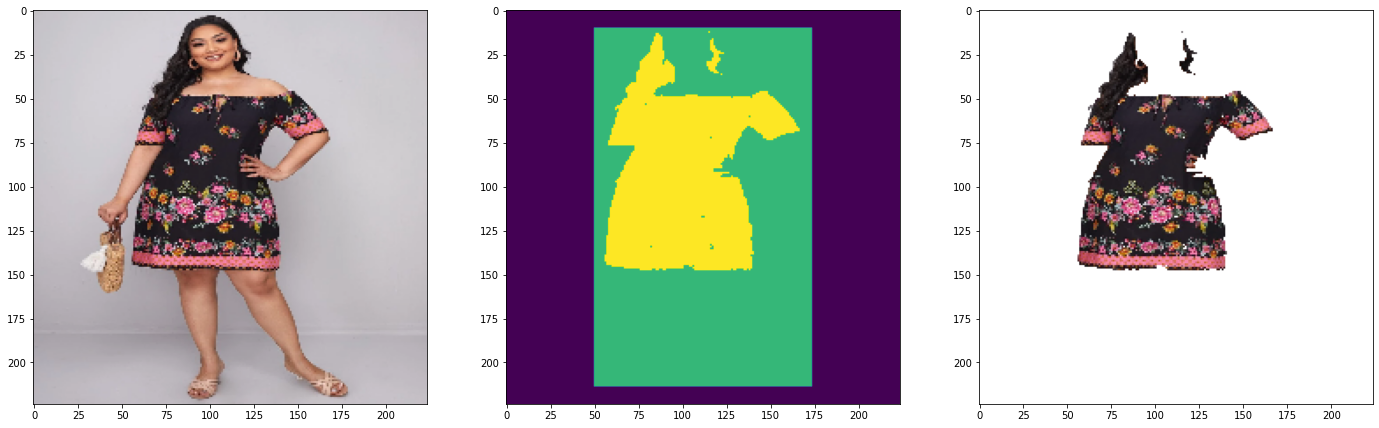

In [ ]:
plt.figure(figsize=(24,12))
original = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/18original.jpg')
original = cv2.resize(original,(224,224))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGRA2RGB))
mask, final = cut(original)
plt.subplot(1,3,2)
plt.imshow(mask)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGRA2RGB))

Con todo esto, tenemos un potente segmentador de vestidos, que fue creado gracias al Autoencoder UNet combinado con inteligentes técnicas de preprocesamiento de imágenes. 

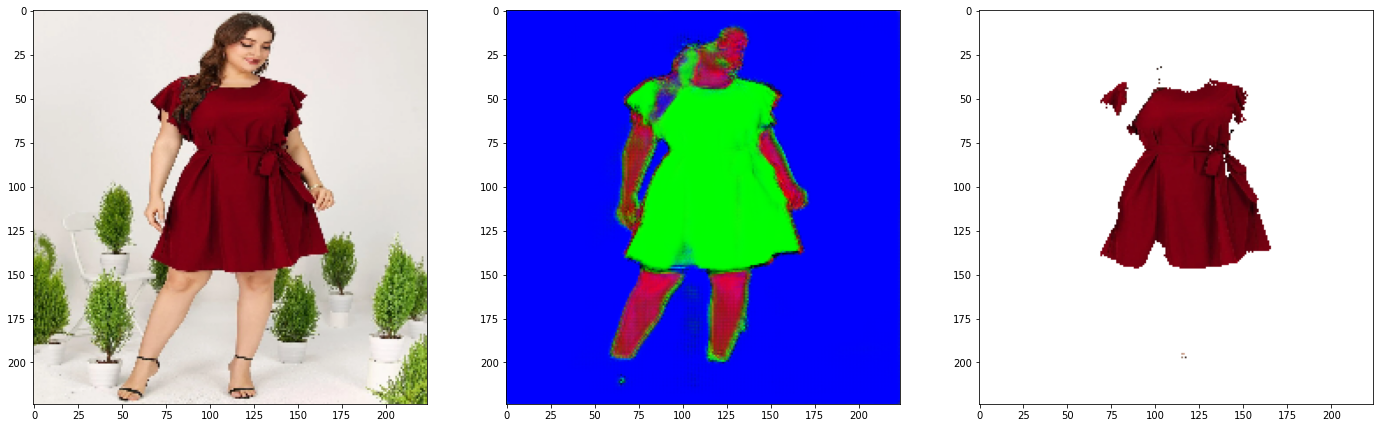

In [ ]:
# Leemos una nueva imágen
plt.figure(figsize=(24,12))
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/17original.jpg')
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(cv2.resize(img.copy(),(224,224)), cv2.COLOR_BGRA2RGB))

# GRUBCUT + Predicción
mask_test, test = cut(img)
pred = UNET.predict(test[None,...])[0]
plt.subplot(1,3,2)
plt.imshow(pred)

### Aplicamos PIXEL TRESHOLD para la mascara
pred_dress = pred.copy()[:,:,1]
pred_dress[pred_dress>=0.90]=1
pred_dress[pred_dress<0.90]=0
real_dress = (cv2.resize(img.copy(),(224,224))*pred_dress[:,:,np.newaxis]).astype('int')
real_dress[pred_dress == 0] = (255, 255, 255)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(real_dress.astype('uint8'), cv2.COLOR_BGRA2RGB))

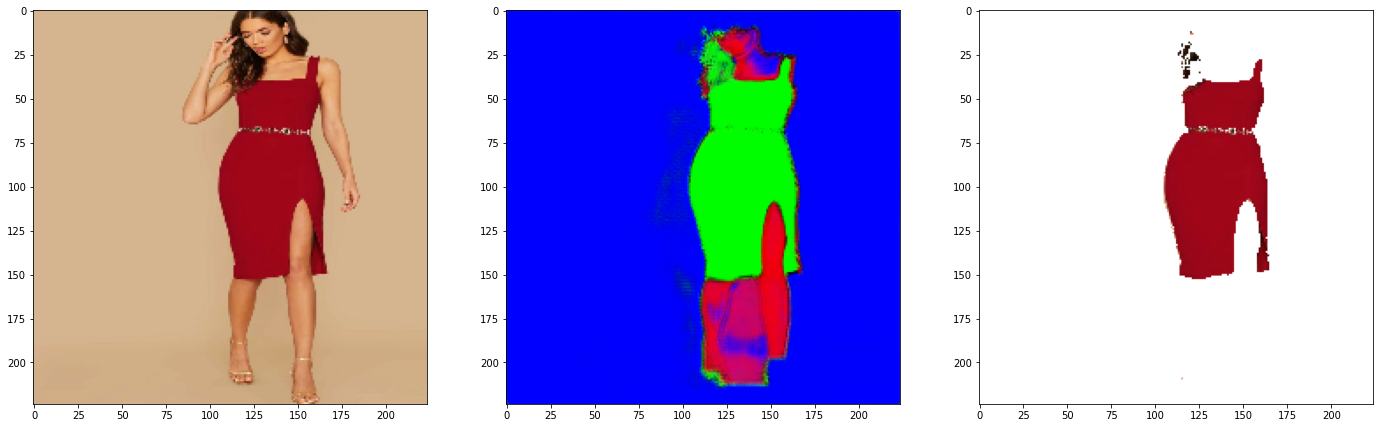

In [ ]:
# Leemos una nueva imágen
plt.figure(figsize=(24,12))
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/MODULO 5 Machine Learning/Proyecto/Segmentar vestido/19original.jpg')
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(cv2.resize(img.copy(),(224,224)), cv2.COLOR_BGRA2RGB))

# GRUBCUT + Predicción
mask_test, test = cut(img)
pred = UNET.predict(test[None,...])[0]
plt.subplot(1,3,2)
plt.imshow(pred)

### Aplicamos PIXEL TRESHOLD para la mascara
pred_dress = pred.copy()[:,:,1]
pred_dress[pred_dress>=0.90]=1
pred_dress[pred_dress<0.90]=0
real_dress = (cv2.resize(img.copy(),(224,224))*pred_dress[:,:,np.newaxis]).astype('int')
real_dress[pred_dress == 0] = (255, 255, 255)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(real_dress.astype('uint8'), cv2.COLOR_BGRA2RGB))